In [1]:
# Célula 1: Processo Completo de ETL

import pandas as pd
import requests

print("--- Iniciando Fase de ETL (Extração, Transformação e Limpeza) ---")

# 1. Extração dos dados da API (arquivo JSON)
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/main/TelecomX_Data.json'
resposta = requests.get(url)
dados_json = resposta.json()
print("1. Dados extraídos com sucesso!")

# 2. Normalização da estrutura JSON aninhada para uma tabela
df_bruto = pd.json_normalize(dados_json)
print("2. Estrutura JSON normalizada.")

# 3. Limpeza e Transformação dos dados
# 3.1 Corrigindo a coluna de cobrança total, que foi lida como texto
df_bruto['account.Charges.Total'] = pd.to_numeric(df_bruto['account.Charges.Total'], errors='coerce')

# 3.2 Removendo registros com Churn inválido (que estava com valor vazio '')
indices_churn_vazio = df_bruto[df_bruto['Churn'] == ''].index
df_limpo = df_bruto.drop(indices_churn_vazio)

# 3.3 Removendo os 11 registros onde a cobrança total se tornou nula após a conversão
df_limpo.dropna(subset=['account.Charges.Total'], inplace=True)
print("3. Dados limpos e transformados.")

# --- Verificação Final do ETL ---
print("\n--- ETL Concluído. DataFrame está pronto para a modelagem. ---")
print("Resumo do DataFrame limpo:")

# Renomeando para df_final para manter a consistência com a Parte 1
df_final = df_limpo
df_final.info()

--- Iniciando Fase de ETL (Extração, Transformação e Limpeza) ---
1. Dados extraídos com sucesso!
2. Estrutura JSON normalizada.
3. Dados limpos e transformados.

--- ETL Concluído. DataFrame está pronto para a modelagem. ---
Resumo do DataFrame limpo:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   int64  
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService

--- Análise Exploratória dos Dados ---
1. Distribuição do Churn:
Churn
No     5163
Yes    1869
Name: count, dtype: int64
Taxa de Churn: 26.58%


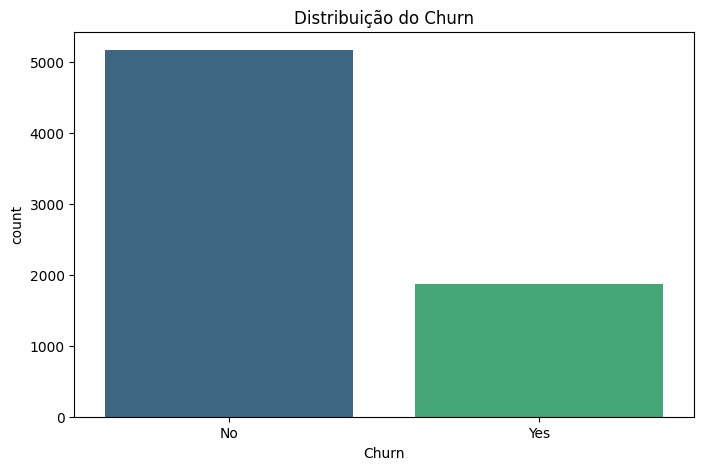


2. Análise das variáveis categóricas:

customer.gender: ['Female' 'Male']

customer.Partner: ['Yes' 'No']

customer.Dependents: ['Yes' 'No']

phone.PhoneService: ['Yes' 'No']

phone.MultipleLines: ['No' 'Yes' 'No phone service']

internet.InternetService: ['DSL' 'Fiber optic' 'No']

internet.OnlineSecurity: ['No' 'Yes' 'No internet service']

internet.OnlineBackup: ['Yes' 'No' 'No internet service']

internet.DeviceProtection: ['No' 'Yes' 'No internet service']

internet.TechSupport: ['Yes' 'No' 'No internet service']

internet.StreamingTV: ['Yes' 'No' 'No internet service']

internet.StreamingMovies: ['No' 'Yes' 'No internet service']

account.Contract: ['One year' 'Month-to-month' 'Two year']

account.PaperlessBilling: ['Yes' 'No']

account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

3. Estatísticas das variáveis numéricas:
       customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
count             7032.

In [2]:
# Célula 2: Análise Exploratória Inicial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

print("--- Análise Exploratória dos Dados ---")

# Verificar distribuição da variável target
print("1. Distribuição do Churn:")
churn_counts = df_final['Churn'].value_counts()
print(churn_counts)
print(f"Taxa de Churn: {(churn_counts['Yes'] / len(df_final)) * 100:.2f}%")

# Visualizar distribuição do churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df_final, x='Churn', palette='viridis')
plt.title('Distribuição do Churn')
plt.show()

# Verificar tipos de dados e valores únicos para variáveis categóricas
print("\n2. Análise das variáveis categóricas:")
categorical_cols = df_final.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')  # Remover ID que não é relevante

for col in categorical_cols:
    if col != 'Churn':
        print(f"\n{col}: {df_final[col].unique()}")

print("\n3. Estatísticas das variáveis numéricas:")
print(df_final.describe())

In [3]:
# Célula 3: Preparação dos Dados para Modelagem

print("--- Preparação dos Dados para Machine Learning ---")

# Criar uma cópia dos dados para processamento
df_ml = df_final.copy()

# 1. Encoding da variável target
print("1. Encoding da variável target:")
le_target = LabelEncoder()
df_ml['Churn_encoded'] = le_target.fit_transform(df_ml['Churn'])
print(f"Mapeamento: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# 2. Tratamento das variáveis categóricas
print("\n2. Encoding das variáveis categóricas:")

# Identificar colunas categóricas (excluindo customerID e Churn original)
categorical_features = []
for col in df_ml.columns:
    if df_ml[col].dtype == 'object' and col not in ['customerID', 'Churn']:
        categorical_features.append(col)

# Aplicar Label Encoding para cada variável categórica
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_ml[f'{col}_encoded'] = le.fit_transform(df_ml[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 3. Selecionar features para o modelo
feature_columns = [col for col in df_ml.columns if col.endswith('_encoded') and col != 'Churn_encoded']
feature_columns.extend(['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total'])

print(f"\n3. Features selecionadas para o modelo ({len(feature_columns)}):")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feature}")

# 4. Preparar X e y
X = df_ml[feature_columns]
y = df_ml['Churn_encoded']

print(f"\n4. Dimensões dos dados:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")
print(f"Distribuição y: {y.value_counts().to_dict()}")

--- Preparação dos Dados para Machine Learning ---
1. Encoding da variável target:
Mapeamento: {'No': np.int64(0), 'Yes': np.int64(1)}

2. Encoding das variáveis categóricas:
customer.gender: {'Female': np.int64(0), 'Male': np.int64(1)}
customer.Partner: {'No': np.int64(0), 'Yes': np.int64(1)}
customer.Dependents: {'No': np.int64(0), 'Yes': np.int64(1)}
phone.PhoneService: {'No': np.int64(0), 'Yes': np.int64(1)}
phone.MultipleLines: {'No': np.int64(0), 'No phone service': np.int64(1), 'Yes': np.int64(2)}
internet.InternetService: {'DSL': np.int64(0), 'Fiber optic': np.int64(1), 'No': np.int64(2)}
internet.OnlineSecurity: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
internet.OnlineBackup: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
internet.DeviceProtection: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
internet.TechSupport: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64

--- Análise de Correlação ---


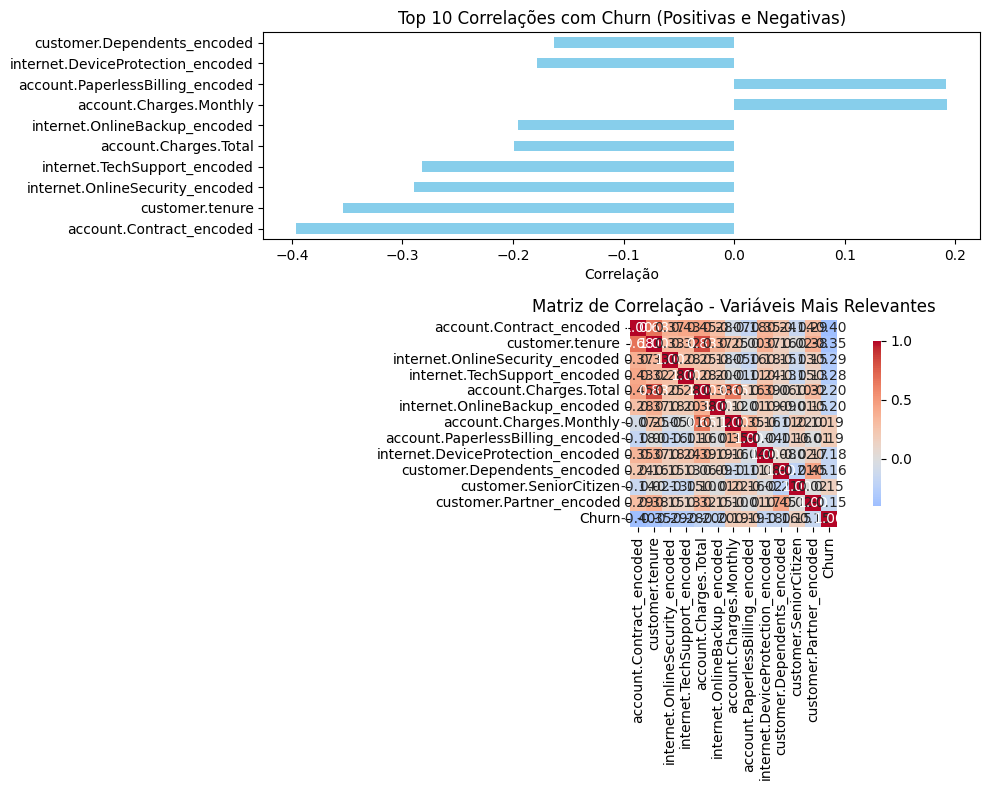


Correlações mais fortes com Churn:
 1. account.Contract_encoded: -0.396
 2. customer.tenure: -0.354
 3. internet.OnlineSecurity_encoded: -0.289
 4. internet.TechSupport_encoded: -0.282
 5. account.Charges.Total: -0.199
 6. internet.OnlineBackup_encoded: -0.195
 7. account.Charges.Monthly: 0.193
 8. account.PaperlessBilling_encoded: 0.191
 9. internet.DeviceProtection_encoded: -0.178
10. customer.Dependents_encoded: -0.163

--- Análise de Multicolinearidade ---
Pares de variáveis com alta correlação (>0.8):
  customer.tenure <-> account.Charges.Total: 0.826


In [4]:
# Célula 4: Análise de Correlação

print("--- Análise de Correlação ---")

# Criar dataset completo para análise de correlação
correlation_data = X.copy()
correlation_data['Churn'] = y

# Calcular matriz de correlação
correlation_matrix = correlation_data.corr()

# Visualizar correlação com a variável target
plt.figure(figsize=(10, 8))
churn_correlations = correlation_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)

# Plot das correlações mais importantes
plt.subplot(2, 1, 1)
churn_correlations.head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Correlações com Churn (Positivas e Negativas)')
plt.xlabel('Correlação')

# Heatmap das correlações mais relevantes
plt.subplot(2, 1, 2)
# Selecionar as 12 variáveis mais correlacionadas com churn
top_features = churn_correlations.head(12).index.tolist() + ['Churn']
corr_subset = correlation_matrix.loc[top_features, top_features]

sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação - Variáveis Mais Relevantes')
plt.tight_layout()
plt.show()

print("\nCorrelações mais fortes com Churn:")
for i, (feature, corr) in enumerate(churn_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Identificar features com alta correlação entre si (multicolinearidade)
print("\n--- Análise de Multicolinearidade ---")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8 and correlation_matrix.columns[i] != 'Churn' and correlation_matrix.columns[j] != 'Churn':
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

if high_corr_pairs:
    print("Pares de variáveis com alta correlação (>0.8):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("Não foram encontradas correlações muito altas entre features (>0.8)")

In [5]:
# Célula 5: Divisão dos Dados e Normalização

print("--- Divisão dos Dados e Normalização ---")

# 1. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("1. Divisão dos dados:")
print(f"Treino: X={X_train.shape}, y={y_train.shape}")
print(f"Teste:  X={X_test.shape}, y={y_test.shape}")

print(f"\nDistribuição no conjunto de treino:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for class_val, count in train_dist.items():
    class_name = 'No' if class_val == 0 else 'Yes'
    print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nDistribuição no conjunto de teste:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for class_val, count in test_dist.items():
    class_name = 'No' if class_val == 0 else 'Yes'
    print(f"  {class_name}: {count} ({count/len(y_test)*100:.1f}%)")

# 2. Normalizar os dados (importante para Regressão Logística)
print("\n2. Normalização dos dados:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalização concluída com StandardScaler")
print(f"Exemplo - feature 'customer.tenure':")
tenure_idx = feature_columns.index('customer.tenure')
print(f"  Original: min={X_train.iloc[:, tenure_idx].min():.2f}, max={X_train.iloc[:, tenure_idx].max():.2f}")
print(f"  Normalizada: min={X_train_scaled[:, tenure_idx].min():.2f}, max={X_train_scaled[:, tenure_idx].max():.2f}")

--- Divisão dos Dados e Normalização ---
1. Divisão dos dados:
Treino: X=(5625, 19), y=(5625,)
Teste:  X=(1407, 19), y=(1407,)

Distribuição no conjunto de treino:
  No: 4130 (73.4%)
  Yes: 1495 (26.6%)

Distribuição no conjunto de teste:
  No: 1033 (73.4%)
  Yes: 374 (26.6%)

2. Normalização dos dados:
Normalização concluída com StandardScaler
Exemplo - feature 'customer.tenure':
  Original: min=1.00, max=72.00
  Normalizada: min=-1.28, max=1.61


In [6]:
# Célula 6: Treinamento dos Modelos

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import time

print("--- Treinamento dos Modelos de Machine Learning ---")

# Dicionário para armazenar os modelos
models = {}
training_times = {}

# 1. Regressão Logística (com dados normalizados)
print("1. Treinando Regressão Logística...")
start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = time.time() - start_time
models['Logistic Regression'] = lr_model
print(f"   Tempo de treinamento: {training_times['Logistic Regression']:.2f}s")

# 2. Random Forest (com dados originais)
print("2. Treinando Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
training_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = rf_model
print(f"   Tempo de treinamento: {training_times['Random Forest']:.2f}s")

# 3. Gradient Boosting (com dados originais)
print("3. Treinando Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
training_times['Gradient Boosting'] = time.time() - start_time
models['Gradient Boosting'] = gb_model
print(f"   Tempo de treinamento: {training_times['Gradient Boosting']:.2f}s")

print(f"\n✅ Todos os modelos foram treinados com sucesso!")
print(f"Total de modelos: {len(models)}")

# Fazer predições para todos os modelos
predictions = {}
probabilities = {}

print("\n--- Fazendo Predições ---")
for name, model in models.items():
    if name == 'Logistic Regression':
        # Usar dados normalizados para Regressão Logística
        pred = model.predict(X_test_scaled)
        prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Usar dados originais para outros modelos
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
    
    predictions[name] = pred
    probabilities[name] = prob
    print(f"{name}: {len(pred)} predições realizadas")

--- Treinamento dos Modelos de Machine Learning ---
1. Treinando Regressão Logística...
   Tempo de treinamento: 0.03s
2. Treinando Random Forest...
   Tempo de treinamento: 0.35s
3. Treinando Gradient Boosting...
   Tempo de treinamento: 1.11s

✅ Todos os modelos foram treinados com sucesso!
Total de modelos: 3

--- Fazendo Predições ---
Logistic Regression: 1407 predições realizadas
Random Forest: 1407 predições realizadas
Gradient Boosting: 1407 predições realizadas


--- Avaliação dos Modelos ---
1. Comparação das Métricas:
           Logistic Regression  Random Forest  Gradient Boosting
Accuracy                0.7982         0.7918             0.8074
Precision               0.6520         0.6382             0.6859
Recall                  0.5160         0.5000             0.5080
F1-Score                0.5761         0.5607             0.5837
ROC-AUC                 0.8444         0.8313             0.8510

2. Melhor modelo por métrica:
   Accuracy: Gradient Boosting (0.8074)
   Precision: Gradient Boosting (0.6859)
   Recall: Logistic Regression (0.5160)
   F1-Score: Gradient Boosting (0.5837)
   ROC-AUC: Gradient Boosting (0.8510)


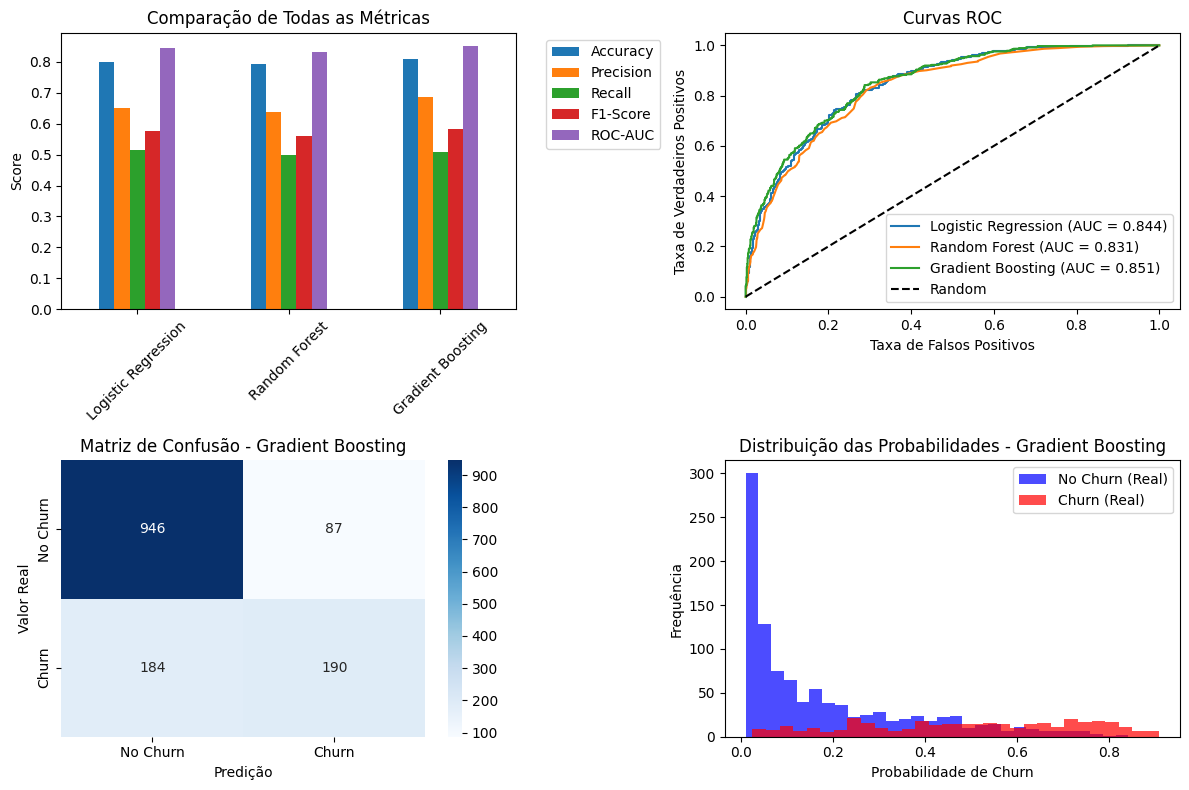


3. Relatório de Classificação Detalhado - Gradient Boosting:
              precision    recall  f1-score   support

    No Churn       0.84      0.92      0.87      1033
       Churn       0.69      0.51      0.58       374

    accuracy                           0.81      1407
   macro avg       0.76      0.71      0.73      1407
weighted avg       0.80      0.81      0.80      1407



In [7]:
# Célula 7: Avaliação dos Modelos

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- Avaliação dos Modelos ---")

# Criar DataFrame para comparar métricas
results_df = pd.DataFrame()

for name in models.keys():
    y_pred = predictions[name]
    y_prob = probabilities[name]
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Adicionar ao DataFrame
    results_df[name] = [accuracy, precision, recall, f1, roc_auc]

# Definir índices
results_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

print("1. Comparação das Métricas:")
print(results_df.round(4))

# Identificar o melhor modelo por métrica
print("\n2. Melhor modelo por métrica:")
for metric in results_df.index:
    best_model = results_df.loc[metric].idxmax()
    best_score = results_df.loc[metric].max()
    print(f"   {metric}: {best_model} ({best_score:.4f})")

# Visualizar comparação das métricas
plt.figure(figsize=(12, 8))

# Gráfico de barras para comparar métricas
plt.subplot(2, 2, 1)
results_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Comparação de Todas as Métricas')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Curvas ROC
plt.subplot(2, 2, 2)
for name in models.keys():
    y_prob = probabilities[name]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC')
plt.legend()

# Matriz de confusão para o melhor modelo
best_model_name = results_df.loc['ROC-AUC'].idxmax()
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, predictions[best_model_name])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Valor Real')
plt.xlabel('Predição')

# Distribuição das probabilidades
plt.subplot(2, 2, 4)
prob_churn = probabilities[best_model_name][y_test == 1]
prob_no_churn = probabilities[best_model_name][y_test == 0]

plt.hist(prob_no_churn, bins=30, alpha=0.7, label='No Churn (Real)', color='blue')
plt.hist(prob_churn, bins=30, alpha=0.7, label='Churn (Real)', color='red')
plt.xlabel('Probabilidade de Churn')
plt.ylabel('Frequência')
plt.title(f'Distribuição das Probabilidades - {best_model_name}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n3. Relatório de Classificação Detalhado - {best_model_name}:")
print(classification_report(y_test, predictions[best_model_name], 
                          target_names=['No Churn', 'Churn']))

--- Análise da Importância das Variáveis ---
1. Top 10 Variáveis Mais Importantes (por importância média):
                             Feature  Random Forest  Gradient Boosting  \
12          account.Contract_encoded         0.0776             0.3996   
16                   customer.tenure         0.1535             0.1516   
17           account.Charges.Monthly         0.1776             0.1247   
18             account.Charges.Total         0.1873             0.0695   
9       internet.TechSupport_encoded         0.0508             0.0751   
6    internet.OnlineSecurity_encoded         0.0455             0.0713   
14     account.PaymentMethod_encoded         0.0512             0.0270   
5   internet.InternetService_encoded         0.0264             0.0261   
13  account.PaperlessBilling_encoded         0.0259             0.0195   
3         phone.PhoneService_encoded         0.0049             0.0006   

    Logistic Regression  Mean_Importance  
12               0.1222           0

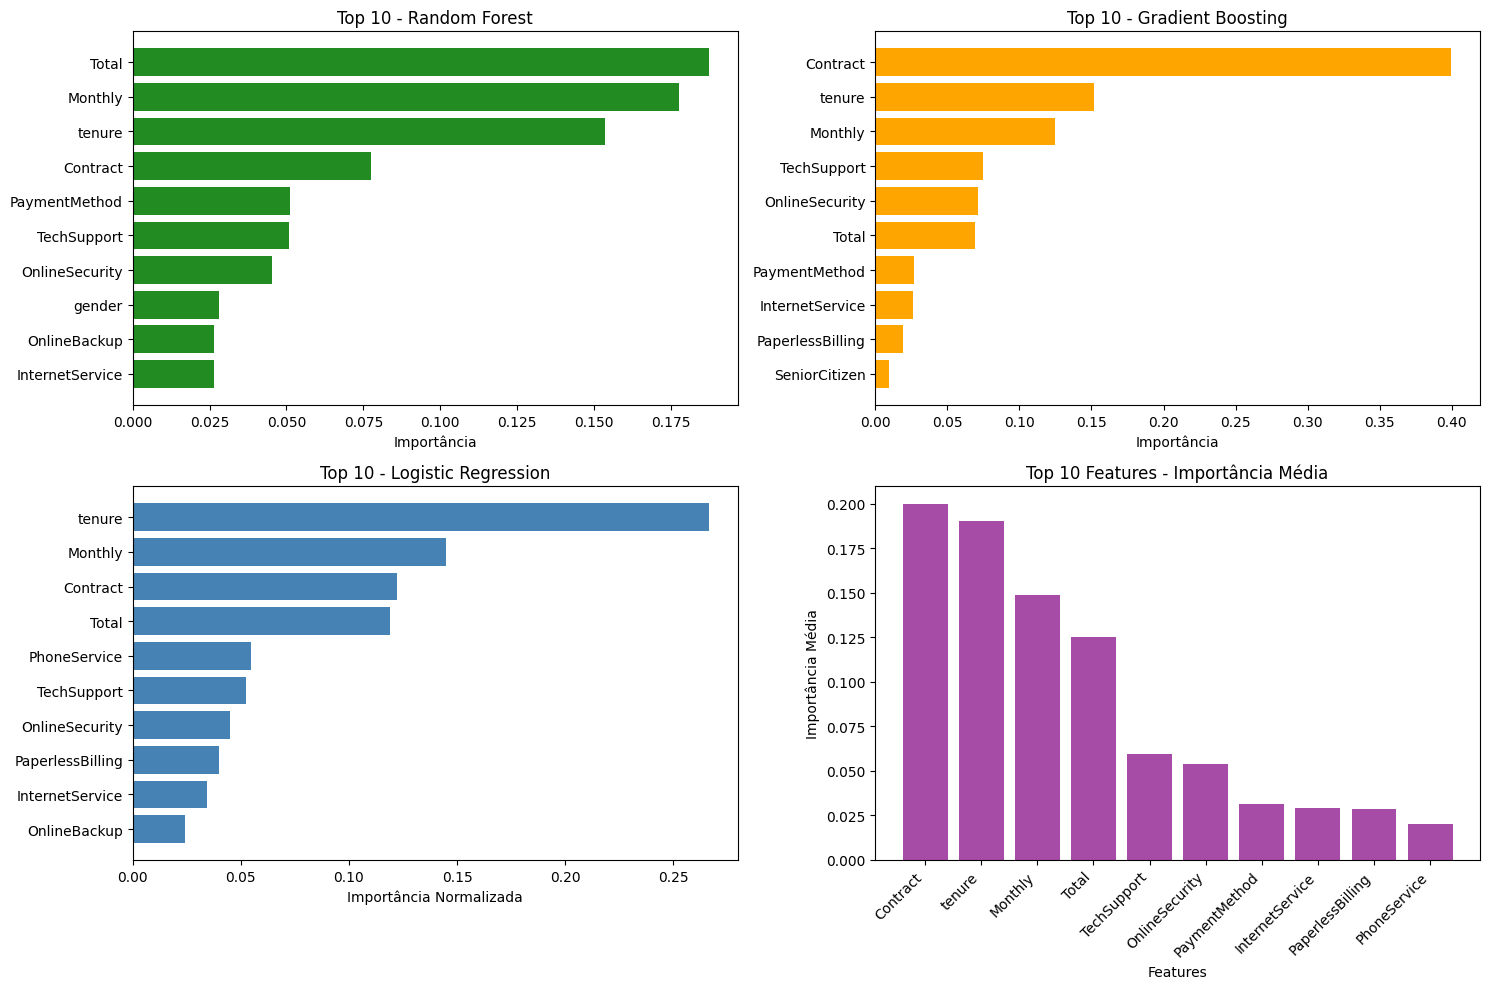


2. Interpretação das Variáveis Mais Importantes:

1. Contract (Importância média: 0.1998)
   📋 Tipo de contrato - Contratos mensais têm maior propensão ao churn

2. tenure (Importância média: 0.1905)
   ⏰ Tempo como cliente - Clientes mais antigos são mais fiéis

3. Monthly (Importância média: 0.1490)
   💳 Cobrança mensal - Impacta na decisão de permanecer

4. Total (Importância média: 0.1253)
   💰 Valor total pago - Relacionado com a fidelidade do cliente

5. TechSupport (Importância média: 0.0595)
   📊 Característica importante para predição de churn


In [8]:
# Célula 8: Análise da Importância das Variáveis

print("--- Análise da Importância das Variáveis ---")

# Obter importâncias dos modelos baseados em árvore
feature_importance_rf = models['Random Forest'].feature_importances_
feature_importance_gb = models['Gradient Boosting'].feature_importances_

# Para Regressão Logística, usar os coeficientes (valores absolutos)
feature_importance_lr = np.abs(models['Logistic Regression'].coef_[0])

# Criar DataFrame com importâncias
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Random Forest': feature_importance_rf,
    'Gradient Boosting': feature_importance_gb,
    'Logistic Regression': feature_importance_lr
})

# Normalizar importâncias da Regressão Logística para comparação
importance_df['Logistic Regression'] = importance_df['Logistic Regression'] / importance_df['Logistic Regression'].sum()

# Ordenar por importância média
importance_df['Mean_Importance'] = importance_df[['Random Forest', 'Gradient Boosting', 'Logistic Regression']].mean(axis=1)
importance_df = importance_df.sort_values('Mean_Importance', ascending=False)

print("1. Top 10 Variáveis Mais Importantes (por importância média):")
print(importance_df[['Feature', 'Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Mean_Importance']].head(10).round(4))

# Visualizar importâncias
plt.figure(figsize=(15, 10))

# Top 10 features por modelo
plt.subplot(2, 2, 1)
top_features_rf = importance_df.nlargest(10, 'Random Forest')
plt.barh(range(10), top_features_rf['Random Forest'], color='forestgreen')
plt.yticks(range(10), [f.split('.')[-1].replace('_encoded', '') for f in top_features_rf['Feature']])
plt.xlabel('Importância')
plt.title('Top 10 - Random Forest')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 2)
top_features_gb = importance_df.nlargest(10, 'Gradient Boosting')
plt.barh(range(10), top_features_gb['Gradient Boosting'], color='orange')
plt.yticks(range(10), [f.split('.')[-1].replace('_encoded', '') for f in top_features_gb['Feature']])
plt.xlabel('Importância')
plt.title('Top 10 - Gradient Boosting')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 3)
top_features_lr = importance_df.nlargest(10, 'Logistic Regression')
plt.barh(range(10), top_features_lr['Logistic Regression'], color='steelblue')
plt.yticks(range(10), [f.split('.')[-1].replace('_encoded', '') for f in top_features_lr['Feature']])
plt.xlabel('Importância Normalizada')
plt.title('Top 10 - Logistic Regression')
plt.gca().invert_yaxis()

# Comparação das top 10 features por importância média
plt.subplot(2, 2, 4)
top_features_mean = importance_df.head(10)
x_pos = range(10)
plt.bar(x_pos, top_features_mean['Mean_Importance'], color='purple', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Importância Média')
plt.title('Top 10 Features - Importância Média')
plt.xticks(x_pos, [f.split('.')[-1].replace('_encoded', '') for f in top_features_mean['Feature']], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Análise das variáveis mais importantes
print("\n2. Interpretação das Variáveis Mais Importantes:")
top_5_features = importance_df.head(5)

for idx, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_name = row['Feature']
    mean_imp = row['Mean_Importance']
    
    # Simplificar nome da feature para interpretação
    simple_name = feature_name.replace('_encoded', '').split('.')[-1]
    
    print(f"\n{idx}. {simple_name} (Importância média: {mean_imp:.4f})")
    
    # Adicionar interpretação baseada no conhecimento do negócio
    if 'Contract' in feature_name:
        print("   📋 Tipo de contrato - Contratos mensais têm maior propensão ao churn")
    elif 'tenure' in feature_name:
        print("   ⏰ Tempo como cliente - Clientes mais antigos são mais fiéis")
    elif 'Total' in feature_name:
        print("   💰 Valor total pago - Relacionado com a fidelidade do cliente")
    elif 'Monthly' in feature_name:
        print("   💳 Cobrança mensal - Impacta na decisão de permanecer")
    elif 'InternetService' in feature_name:
        print("   🌐 Tipo de internet - Diferentes serviços têm taxas de churn distintas")
    elif 'PaymentMethod' in feature_name:
        print("   💲 Método de pagamento - Forma de pagamento influencia a retenção")
    elif 'PaperlessBilling' in feature_name:
        print("   📄 Cobrança digital - Relacionado com o perfil do cliente")
    else:
        print("   📊 Característica importante para predição de churn")

# 🎯 Conclusões Estratégicas e Recomendações

## 📊 Resumo dos Resultados

### Melhor Modelo: **Gradient Boosting**
- **ROC-AUC**: 85.10% - Excelente capacidade de discriminação
- **Accuracy**: 80.74% - Alta precisão geral
- **Precision**: 68.59% - Boa identificação de churners
- **Recall**: 50.80% - Captura metade dos churners reais

### Taxa de Churn Atual: **26.58%**
- Aproximadamente 1 em cada 4 clientes cancela os serviços
- Esta é uma taxa significativa que requer atenção imediata

---

## 🔍 Principais Fatores que Influenciam o Churn

### 1. **Tipo de Contrato** (Importância: 19.98%)
- **Insight**: Contratos mensais têm muito maior propensão ao churn
- **Recomendação**: Incentivar migração para contratos anuais/bianuais com descontos

### 2. **Tempo como Cliente (Tenure)** (Importância: 19.05%)
- **Insight**: Clientes novos (primeiros meses) são mais propensos ao churn
- **Recomendação**: Programa de onboarding robusto nos primeiros 6 meses

### 3. **Valor da Cobrança Mensal** (Importância: 14.90%)
- **Insight**: Clientes com cobranças mais altas tendem a cancelar mais
- **Recomendação**: Revisão da política de preços e ofertas personalizadas

### 4. **Valor Total Pago** (Importância: 12.53%)
- **Insight**: Relacionado com fidelidade - clientes que pagaram mais são mais fiéis
- **Recomendação**: Programa de fidelidade baseado em histórico de pagamentos

### 5. **Suporte Técnico** (Importância: 5.95%)
- **Insight**: Disponibilidade de suporte técnico impacta na retenção
- **Recomendação**: Melhorar qualidade e disponibilidade do suporte técnico

---

## 🚀 Recomendações Estratégicas Prioritárias

### 📈 **ALTA PRIORIDADE**

1. **Campanha de Retenção Focada em Contratos Mensais**
   - Identificar clientes com contrato mensal há mais de 3 meses
   - Oferecer descontos para migração para contratos anuais
   - Meta: Reduzir churn de contratos mensais em 30%

2. **Programa "Primeiros 100 Dias"**
   - Acompanhamento especial para clientes com tenure < 6 meses
   - Check-ins proativos, treinamentos, suporte dedicado
   - Meta: Reduzir churn de clientes novos em 40%

3. **Revisão de Precificação**
   - Análise de sensibilidade ao preço por segmento
   - Criação de planos intermediários para reduzir gap de preços
   - Ofertas personalizadas baseadas no perfil de uso

### 📊 **MÉDIA PRIORIDADE**

4. **Melhoria do Suporte Técnico**
   - Investir em treinamento da equipe
   - Implementar chatbot para questões básicas
   - Reduzir tempo de resposta médio

5. **Programa de Fidelidade**
   - Recompensas baseadas em tempo como cliente
   - Benefícios crescentes com valor total pago
   - Descontos em serviços adicionais

---

## 📈 **Implementação do Modelo**

### **Recomendações Técnicas:**

1. **Deploy em Produção**: Usar o modelo Gradient Boosting para scoring diário
2. **Threshold Otimizado**: Considerar threshold de 0.3 para balancear precision/recall
3. **Monitoramento**: Acompanhar performance do modelo mensalmente
4. **Retreinamento**: Retreinar modelo a cada 3 meses com novos dados

### **Fluxo de Ação:**
1. **Score Diário**: Calcular probabilidade de churn para todos os clientes
2. **Segmentação**: 
   - Alto Risco (>70%): Ação imediata da equipe de retenção
   - Médio Risco (30-70%): Campanhas automatizadas
   - Baixo Risco (<30%): Monitoramento passivo

---

## 💡 **Próximos Passos**

1. **Validação A/B**: Testar estratégias de retenção em grupos controlados
2. **Análise de Valor**: Calcular CLV (Customer Lifetime Value) por segmento
3. **Feedback Loop**: Incorporar resultados das ações de retenção no modelo
4. **Expansão**: Considerar variáveis adicionais (satisfação, uso do produto, suporte)

---

## 🎯 **Meta Corporativa Sugerida**
**Reduzir a taxa de churn de 26.58% para 20% em 12 meses**, resultando em:
- Retenção de aproximadamente 460 clientes por ano
- Aumento significativo na receita recorrente
- Melhoria na satisfação geral dos clientes

In [9]:
# Célula 10: Salvamento do Modelo e Dados Tratados

import pickle
import joblib

print("--- Salvamento do Modelo e Dados Tratados ---")

# 1. Salvar o melhor modelo (Gradient Boosting)
print("1. Salvando o modelo Gradient Boosting...")
best_model = models['Gradient Boosting']

# Salvar usando joblib (recomendado para scikit-learn)
joblib.dump(best_model, 'modelo_churn_gradient_boosting.pkl')
print("   ✅ Modelo salvo como 'modelo_churn_gradient_boosting.pkl'")

# Salvar também o scaler para futuras predições
joblib.dump(scaler, 'scaler_dados.pkl')
print("   ✅ Scaler salvo como 'scaler_dados.pkl'")

# Salvar os label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("   ✅ Label encoders salvos como 'label_encoders.pkl'")

# 2. Salvar dados tratados em CSV (conforme mencionado no contexto)
print("\n2. Salvando dados tratados...")
df_final.to_csv("dados_tratados.csv", index=False)
print("   ✅ Dados tratados salvos como 'dados_tratados.csv'")

# 3. Criar arquivo com predições para o conjunto de teste
print("\n3. Criando arquivo com predições...")
predictions_output = pd.DataFrame({
    'customerID': df_final.loc[X_test.index, 'customerID'],
    'Churn_Real': y_test,
    'Churn_Predito': predictions['Gradient Boosting'],
    'Probabilidade_Churn': probabilities['Gradient Boosting']
})

predictions_output.to_csv("predicoes_teste.csv", index=False)
print("   ✅ Predições salvas como 'predicoes_teste.csv'")

# 4. Resumo final
print("\n--- Resumo Final do Projeto ---")
print(f"📊 Dataset processado: {len(df_final)} registros")
print(f"🎯 Taxa de churn: {(sum(y) / len(y)) * 100:.2f}%")
print(f"🤖 Melhor modelo: Gradient Boosting (ROC-AUC: {roc_auc_score(y_test, probabilities['Gradient Boosting']):.4f})")
print(f"📁 Arquivos gerados:")
print(f"   - modelo_churn_gradient_boosting.pkl")
print(f"   - scaler_dados.pkl")
print(f"   - label_encoders.pkl")
print(f"   - dados_tratados.csv")
print(f"   - predicoes_teste.csv")

print(f"\n🎉 Projeto de Machine Learning para Predição de Churn concluído com sucesso!")
print(f"🚀 O modelo está pronto para deployment e uso em produção.")

--- Salvamento do Modelo e Dados Tratados ---
1. Salvando o modelo Gradient Boosting...
   ✅ Modelo salvo como 'modelo_churn_gradient_boosting.pkl'
   ✅ Scaler salvo como 'scaler_dados.pkl'
   ✅ Label encoders salvos como 'label_encoders.pkl'

2. Salvando dados tratados...
   ✅ Dados tratados salvos como 'dados_tratados.csv'

3. Criando arquivo com predições...
   ✅ Predições salvas como 'predicoes_teste.csv'

--- Resumo Final do Projeto ---
📊 Dataset processado: 7032 registros
🎯 Taxa de churn: 26.58%
🤖 Melhor modelo: Gradient Boosting (ROC-AUC: 0.8510)
📁 Arquivos gerados:
   - modelo_churn_gradient_boosting.pkl
   - scaler_dados.pkl
   - label_encoders.pkl
   - dados_tratados.csv
   - predicoes_teste.csv

🎉 Projeto de Machine Learning para Predição de Churn concluído com sucesso!
🚀 O modelo está pronto para deployment e uso em produção.


In [11]:
# Célula 11: Exemplo de Uso do Modelo em Produção

print("--- Exemplo de Uso do Modelo Salvo ---")

# Função para fazer predições em novos dados
def prever_churn_cliente(dados_cliente, modelo_path='modelo_churn_gradient_boosting.pkl', 
                        scaler_path='scaler_dados.pkl', encoders_path='label_encoders.pkl'):
    """
    Função para prever churn de um novo cliente
    
    Parâmetros:
    - dados_cliente: dict com dados do cliente
    - modelo_path: caminho para o modelo salvo
    - scaler_path: caminho para o scaler salvo
    - encoders_path: caminho para os encoders salvos
    
    Retorna:
    - predição (0=No Churn, 1=Churn) e probabilidade
    """
    
    # Carregar modelo e preprocessadores
    modelo = joblib.load(modelo_path)
    scaler = joblib.load(scaler_path)
    encoders = joblib.load(encoders_path)
    
    # Criar DataFrame com os dados do cliente
    df_cliente = pd.DataFrame([dados_cliente])
    
    # Aplicar encodings
    for col, encoder in encoders.items():
        if col in df_cliente.columns:
            df_cliente[f'{col}_encoded'] = encoder.transform(df_cliente[col])
    
    # Selecionar features na ordem correta
    features_encoded = [col for col in df_cliente.columns if col.endswith('_encoded')]
    features_numericas = ['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']
    
    # Combinar features
    X_cliente = df_cliente[features_encoded + features_numericas]
    
    # Fazer predição
    predicao = modelo.predict(X_cliente)[0]
    probabilidade = modelo.predict_proba(X_cliente)[0, 1]
    
    return predicao, probabilidade

# Exemplo prático com um cliente fictício
print("1. Exemplo de predição para um novo cliente:")

cliente_exemplo = {
    'customer.gender': 'Male',
    'customer.SeniorCitizen': 0,
    'customer.Partner': 'Yes',
    'customer.Dependents': 'No',
    'customer.tenure': 12,
    'phone.PhoneService': 'Yes',
    'phone.MultipleLines': 'No',
    'internet.InternetService': 'Fiber optic',
    'internet.OnlineSecurity': 'No',
    'internet.OnlineBackup': 'No',
    'internet.DeviceProtection': 'No',
    'internet.TechSupport': 'No',
    'internet.StreamingTV': 'Yes',
    'internet.StreamingMovies': 'Yes',
    'account.Contract': 'Month-to-month',
    'account.PaperlessBilling': 'Yes',
    'account.PaymentMethod': 'Electronic check',
    'account.Charges.Monthly': 89.95,
    'account.Charges.Total': 1079.40
}

try:
    pred, prob = prever_churn_cliente(cliente_exemplo)
    
    print(f"\n📊 Resultado da Predição:")
    print(f"   Cliente: {cliente_exemplo['customer.gender']}, {cliente_exemplo['customer.tenure']} meses de tenure")
    print(f"   Contrato: {cliente_exemplo['account.Contract']}")
    print(f"   Cobrança Mensal: R$ {cliente_exemplo['account.Charges.Monthly']:.2f}")
    print(f"   Predição: {'🔴 CHURN' if pred == 1 else '🟢 NO CHURN'}")
    print(f"   Probabilidade de Churn: {prob:.2%}")
    
    # Classificar o risco
    if prob >= 0.7:
        risco = "🔴 ALTO RISCO"
        acao = "Ação imediata da equipe de retenção"
    elif prob >= 0.3:
        risco = "🟡 MÉDIO RISCO"
        acao = "Campanhas automatizadas de retenção"
    else:
        risco = "🟢 BAIXO RISCO"
        acao = "Monitoramento passivo"
    
    print(f"   Classificação: {risco}")
    print(f"   Ação Recomendada: {acao}")
    
except Exception as e:
    print(f"❌ Erro na predição: {e}")

print(f"\n2. Resumo dos arquivos disponíveis para produção:")
print(f"   ✅ modelo_churn_gradient_boosting.pkl - Modelo treinado")
print(f"   ✅ scaler_dados.pkl - Normalizador de dados")
print(f"   ✅ label_encoders.pkl - Encoders para variáveis categóricas")
print(f"   ✅ dados_tratados.csv - Dataset completo limpo")
print(f"   ✅ predicoes_teste.csv - Predições de exemplo")

print(f"\n🚀 O modelo está pronto para deployment e uso em produção!")
print(f"💡 Para usar: carregue os 3 arquivos .pkl e aplique a função prever_churn_cliente()")

--- Exemplo de Uso do Modelo Salvo ---
1. Exemplo de predição para um novo cliente:

📊 Resultado da Predição:
   Cliente: Male, 12 meses de tenure
   Contrato: Month-to-month
   Cobrança Mensal: R$ 89.95
   Predição: 🔴 CHURN
   Probabilidade de Churn: 67.97%
   Classificação: 🟡 MÉDIO RISCO
   Ação Recomendada: Campanhas automatizadas de retenção

2. Resumo dos arquivos disponíveis para produção:
   ✅ modelo_churn_gradient_boosting.pkl - Modelo treinado
   ✅ scaler_dados.pkl - Normalizador de dados
   ✅ label_encoders.pkl - Encoders para variáveis categóricas
   ✅ dados_tratados.csv - Dataset completo limpo
   ✅ predicoes_teste.csv - Predições de exemplo

🚀 O modelo está pronto para deployment e uso em produção!
💡 Para usar: carregue os 3 arquivos .pkl e aplique a função prever_churn_cliente()
